In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
import warnings

# Machine learning libraries for XGBoost
import xgboost as xgb
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import stats 
import optuna

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


c:\Users\Admin\Downloads\Autoscaling-Analysis\AS_venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def calculate_metrics(actual, predicted):
    """
    Calculate evaluation metrics for time series forecasting.
    
    Parameters:
    -----------
    actual : pd.Series or np.array
        Actual values
    predicted : pd.Series or np.array
        Predicted values
        
    Returns:
    --------
    dict : Dictionary containing MSE, RMSE, MAE, and MAPE
    """
    # Ensure inputs are aligned if they are pandas Series
    if isinstance(actual, pd.Series) and isinstance(predicted, pd.Series):
        # Align predicted to actual's index (handling gaps in actual)
        predicted = predicted.reindex(actual.index)
    
    # Remove any NaN values (e.g., from alignment mismatches)
    if isinstance(actual, pd.Series):
        valid_mask = ~np.isnan(actual) & ~np.isnan(predicted)
        actual_clean = actual[valid_mask]
        predicted_clean = predicted[valid_mask]
    else:
        actual_clean = actual
        predicted_clean = predicted

    mse = mean_squared_error(actual_clean, predicted_clean)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual_clean, predicted_clean)
    
    # MAPE (avoid division by zero)
    mask = actual_clean != 0
    if isinstance(actual_clean, pd.Series):
        mape = np.mean(np.abs((actual_clean[mask] - predicted_clean[mask]) / actual_clean[mask])) * 100
    else:
        mape = np.mean(np.abs((actual_clean[mask] - predicted_clean[mask]) / actual_clean[mask])) * 100
    
    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    }

## 1.2 Setup Paths and Load Data

We'll use the cleaned data from the data processing pipeline. The data is available at three aggregation levels:
- `data_1m.csv`: 1-minute aggregation
- `data_5m.csv`: 5-minute aggregation (primary focus)
- `data_15m.csv`: 15-minute aggregation

We'll focus on the **5-minute aggregation** as it provides a good balance between:
- **Granularity:** Captures important short-term patterns
- **Noise reduction:** Smoother than 1-minute data
- **Computational efficiency:** More manageable than 1-minute data
- **Forecast horizon:** Suitable for short-term autoscaling decisions

In [4]:
# Setup project paths
PROJECT_ROOT = Path().resolve().parent.parent
DATA_CLEANED_DIR = PROJECT_ROOT / "data" / "cleaned"

print(f"Project root: {PROJECT_ROOT}")
print(f"Cleaned data directory: {DATA_CLEANED_DIR}")

# Load data
data_1m_path = DATA_CLEANED_DIR / 'data_1m.csv'
data_5m_path = DATA_CLEANED_DIR / 'data_5m.csv'
data_15m_path = DATA_CLEANED_DIR / 'data_15m.csv'

df_1m = pd.read_csv(data_1m_path, index_col=0, parse_dates=True)
df_5m = pd.read_csv(data_5m_path, index_col=0, parse_dates=True)
df_15m = pd.read_csv(data_15m_path, index_col=0, parse_dates=True)

data_files = {
    "1m": data_1m_path,
    "5m": data_5m_path,
    "15m": data_15m_path
}

dfs = {}

for tf, path in data_files.items():
    if path.exists():
        df = pd.read_csv(path, index_col=0, parse_dates=True)
        dfs[tf] = df

        print(f"\n✓ Successfully loaded {tf} data from: {path}")
        print(f"✓ Data shape: {df.shape}")
        print(f"✓ Date range: {df.index.min()} to {df.index.max()}")
    else:
        raise FileNotFoundError(f"Data file not found: {path}")

# Define system downtime period (Aug 1-3, 1995 due to storm)
# Note: This period contains mock data, not gaps in the dataset
# Apply timezone from data to ensure compatibility
data_tz = df_5m.index.tz
downtime_start = pd.Timestamp('1995-08-01').tz_localize(data_tz)
downtime_end = pd.Timestamp('1995-08-03').tz_localize(data_tz)

Project root: C:\Users\Admin\Downloads\Autoscaling-Analysis
Cleaned data directory: C:\Users\Admin\Downloads\Autoscaling-Analysis\data\cleaned

✓ Successfully loaded 1m data from: C:\Users\Admin\Downloads\Autoscaling-Analysis\data\cleaned\data_1m.csv
✓ Data shape: (87840, 20)
✓ Date range: 1995-07-02 00:00:00-04:00 to 1995-08-31 23:59:00-04:00

✓ Successfully loaded 5m data from: C:\Users\Admin\Downloads\Autoscaling-Analysis\data\cleaned\data_5m.csv
✓ Data shape: (17568, 20)
✓ Date range: 1995-07-02 00:00:00-04:00 to 1995-08-31 23:55:00-04:00

✓ Successfully loaded 15m data from: C:\Users\Admin\Downloads\Autoscaling-Analysis\data\cleaned\data_15m.csv
✓ Data shape: (5856, 20)
✓ Date range: 1995-07-02 00:00:00-04:00 to 1995-08-31 23:45:00-04:00


In [5]:
def check_and_plot_data(df):
    print("\n--- INFO ---")
    print(df.info())
    
    print("\n--- STATISTICS ---")
    print(df.describe())
    
    plt.figure(figsize=(15, 6))
    plt.plot(df.index, df['requests_target'], label='Requests (Target)', color='#1f77b4', linewidth=1)
    
    # Highlight vùng Test (Sau ngày 23/08)
    test_start_date = '1995-08-23 00:00:00'
    plt.axvline(pd.to_datetime(test_start_date), color='red', linestyle='--', label='Train/Test Split')
    
    plt.title('Tổng quan dữ liệu Requests', fontsize=14)
    plt.ylabel('Số lượng Request')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


--- INFO ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17568 entries, 1995-07-02 00:00:00-04:00 to 1995-08-31 23:55:00-04:00
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   requests             17568 non-null  int64  
 1   bytes                17568 non-null  int64  
 2   hosts                17568 non-null  int64  
 3   errors               17568 non-null  int64  
 4   error_rate           17568 non-null  float64
 5   requests_target      17568 non-null  int64  
 6   req_lag_1            17568 non-null  float64
 7   req_lag_12           17568 non-null  float64
 8   req_lag_288          17568 non-null  float64
 9   rolling_mean_1h      17568 non-null  float64
 10  rolling_std_1h       17568 non-null  float64
 11  rolling_mean_24h     17568 non-null  float64
 12  err_lag_1            17568 non-null  float64
 13  err_rolling_mean_1h  17568 non-null  float64
 14  hour_of_day          1756

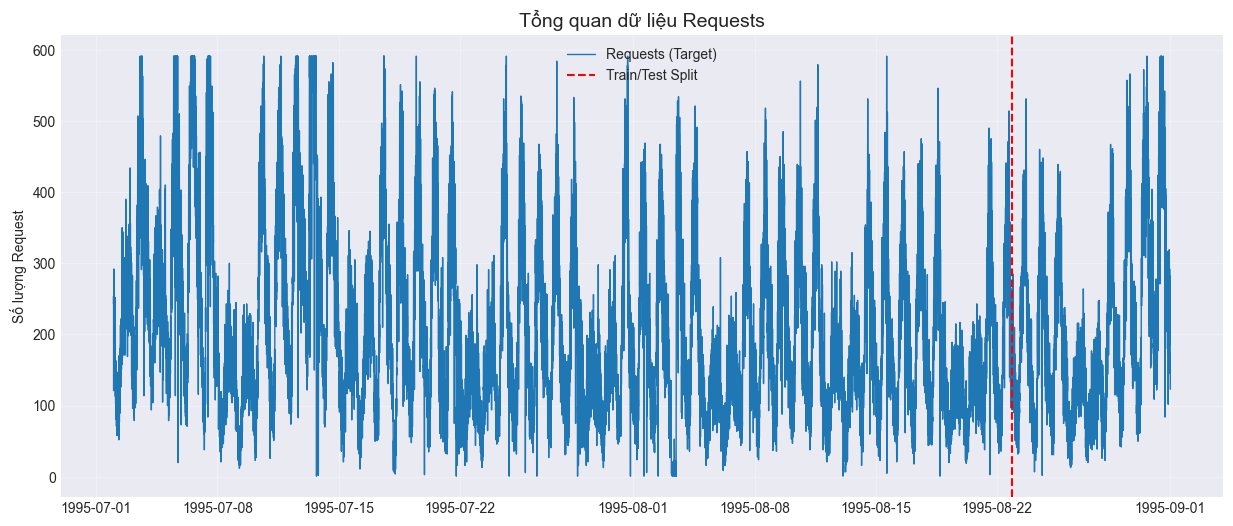

In [6]:
check_and_plot_data(df_5m)

In [7]:
df_5m.head(2)

,requests,bytes,hosts,errors,error_rate,requests_target,req_lag_1,req_lag_12,req_lag_288,rolling_mean_1h,rolling_std_1h,rolling_mean_24h,err_lag_1,err_rolling_mean_1h,hour_of_day,day_of_week,is_weekend,hour_sin,hour_cos,is_spike
timestamp,,,,,,,,,,,,,,,,,,,,
1995-07-02 00:00:00-04:00,243,4199114,50,3,0.012346,243,149.0,232.0,301.0,238.666667,56.633324,224.500000,0.013423,0.004610,0,6,1,0.0,1.0,0
1995-07-02 00:05:00-04:00,254,6328419,60,1,0.003937,254,243.0,235.0,267.0,240.250000,56.786882,224.454861,0.012346,0.004938,0,6,1,0.0,1.0,0


In [13]:
def select_features_xgboost(df, include_target=True):
    """
    Chọn các feature dùng cho XGBoost (1 row = 1 sample)
    """
    selected_features = [
        'req_lag_1',           # Request 5 phút trước
        'req_lag_12',          # Request 1 giờ trước  
        'req_lag_288',         # Request 24h trước
        'rolling_mean_1h',     # Trung bình 1h (đến t-1)
        'rolling_std_1h',      # Độ lệch chuẩn 1h (đến t-1)
        'err_lag_1',           # Error rate 5 phút trước
        'err_rolling_mean_1h', # Trung bình error 1h (đến t-1)
        'hour_sin',            # Giờ (cyclic)
        'hour_cos',            # Giờ (cyclic)
        'day_of_week',         # Ngày trong tuần
    ]

    if include_target:
        selected_features.append('requests_target')  # THÊM TARGET
    
    return df[selected_features]


In [17]:
def prepare_data_for_xgboost(df, target_col='requests_target'):
    # Train: đến 16/08 (60%)
    # Validation: 17/08 - 22/08 (20%)
    # Test: từ 23/08 (20%)
    train_cutoff = '1995-08-16 23:59:59'
    val_cutoff = '1995-08-22 23:59:59'
        
    train_df = df[df.index <= train_cutoff]
    val_df = df[(df.index > train_cutoff) & (df.index <= val_cutoff)]
    test_df = df[df.index > val_cutoff]
        
    print(f"Train size: {len(train_df)} | Validation size: {len(val_df)} | Test size: {len(test_df)}")

    feature_cols = [col for col in df.columns if col != target_col]

    X_train = train_df[feature_cols]
    X_val = val_df[feature_cols]
    X_test = test_df[feature_cols]
    
    y_train = train_df[target_col]
    y_val = val_df[target_col]
    y_test = test_df[target_col]
    
    return X_train, X_val, X_test, y_train, y_val, y_test


In [21]:
df_selected = select_features_xgboost(df_5m, include_target=True)

In [18]:
X_train, X_val, X_test, y_train, y_val, y_test = prepare_data_for_xgboost(df_xgboost_input)

Train size: 13248 | Validation size: 1728 | Test size: 2592


In [ ]:
class XGBoostModel:
    """
    XGBoost model cho time series forecasting
    """
    
    def __init__(self, model_params=None):
        """
        Khởi tạo XGBoost model
        
        Args:
            model_params: Dictionary của XGBoost parameters
        """
        if model_params is None:
            model_params = {
                'n_estimators': 300,
                'max_depth': 6,
                'learning_rate': 0.1,
                'subsample': 0.8,
                'colsample_bytree': 0.8,
                'random_state': 42,
                'n_jobs': -1,
                'verbosity': 0
            }
        
        self.model = xgb.XGBRegressor(**model_params)
        self.feature_importance = None
        self.is_trained = False

In [29]:
class XGBoostModel:
    """
    XGBoost model cho time series forecasting
    """
    
    def __init__(self, model_params=None):
        """
        Khởi tạo XGBoost model
        
        Args:
            model_params: Dictionary của XGBoost parameters
        """
        if model_params is None:
            model_params = {
                'n_estimators': 300,
                'max_depth': 6,
                'learning_rate': 0.1,
                'subsample': 0.8,
                'colsample_bytree': 0.8,
                'random_state': 42,
                'n_jobs': -1,
                'verbosity': 0
            }
        
        self.model = xgb.XGBRegressor(**model_params)
        self.feature_importance = None
        self.is_trained = False
        
    def prepare_data(self, df, target_col='requests_target'):
        """
        Chuẩn bị data cho XGBoost (đã có trong code của bạn)
        
        Returns:
            X_train, X_val, X_test, y_train, y_val, y_test
        """
        # Cutoff dates
        train_cutoff = '1995-08-16 23:59:59'
        val_cutoff = '1995-08-22 23:59:59'
        
        # Split
        train_df = df[df.index <= train_cutoff]
        val_df = df[(df.index > train_cutoff) & (df.index <= val_cutoff)]
        test_df = df[df.index > val_cutoff]
        
        print(f"Data Split:")
        print(f"   Train: {len(train_df)} samples")
        print(f"   Val:   {len(val_df)} samples") 
        print(f"   Test:  {len(test_df)} samples")
        
        # Tách features và target
        feature_cols = [col for col in df.columns if col != target_col]
        
        X_train = train_df[feature_cols]
        X_val = val_df[feature_cols]
        X_test = test_df[feature_cols]
        
        y_train = train_df[target_col]
        y_val = val_df[target_col]
        y_test = test_df[target_col]
        
        return X_train, X_val, X_test, y_train, y_val, y_test, feature_cols
    
    def train(self, X_train, y_train, X_val=None, y_val=None):
        """
        Train XGBoost model
        
        Args:
            X_train, y_train: Training data
            X_val, y_val: Validation data (cho early stopping)
        """
        print("Training XGBoost model...")
        
        if X_val is not None and y_val is not None:
            self.model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                early_stopping_rounds=50,
                verbose=10
            )
        else:
            self.model.fit(X_train, y_train)
        
        self.is_trained = True
        self.feature_importance = pd.DataFrame({
            'feature': X_train.columns,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print("Training completed!")
        
    def predict(self, X):
        """
        Dự đoán với trained model
        """
        if not self.is_trained:
            raise ValueError("Model chưa được train")
        
        return self.model.predict(X)
    
    def evaluate(self, X_test, y_test, set_name="Test"):
        """
        Đánh giá model
        """
        y_pred = self.predict(X_test)
        
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
        
        print(f"\n{set_name} Set Performance:")
        print(f"   MAE:  {mae:.2f}")
        print(f"   RMSE: {rmse:.2f}")
        print(f"   MAPE: {mape:.2f}%")
        print(f"   MSE:  {mse:.2f}")
        
        return {
            'mae': mae,
            'mse': mse,  
            'rmse': rmse,
            'mape': mape,
            'predictions': y_pred,
            'actual': y_test.values
        }
    
    def plot_feature_importance(self, top_n=15):
        """
        Vẽ biểu đồ feature importance
        """
        if self.feature_importance is None:
            print("Chưa có feature importance!")
            return
        
        plt.figure(figsize=(10, 6))
        top_features = self.feature_importance.head(top_n)
        
        plt.barh(range(len(top_features)), top_features['importance'])
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Importance')
        plt.title(f'Top {top_n} Feature Importance')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    
    def plot_predictions_vs_actual(self, y_true, y_pred, title="Predictions vs Actual"):
        """
        Vẽ so sánh predictions vs actual values
        """
        plt.figure(figsize=(12, 6))
        
        n_plot = min(200, len(y_true))
        indices = range(n_plot)
        
        plt.plot(indices, y_true[:n_plot], 'b-', label='Actual', alpha=0.7)
        plt.plot(indices, y_pred[:n_plot], 'r-', label='Predicted', alpha=0.7)
        
        plt.xlabel('Sample Index')
        plt.ylabel('Request Count')
        plt.title(title)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    def save_model(self, filepath):
        """
        Lưu model
        """
        import joblib
        joblib.dump(self.model, filepath)
        print(f"Model saved to {filepath}")
    
    def load_model(self, filepath):
        """
        Load model
        """
        import joblib
        self.model = joblib.load(filepath)
        self.is_trained = True
        print(f"Model loaded from {filepath}")

In [27]:
def run_xgboost():
    """
    Pipeline cho XGBoost
    """

    print("\nINITIALIZING XGBOOST MODEL...")
    xgb_model = XGBoostModel()

    print("\nPREPARING DATA SPLITS...")
    X_train, X_val, X_test, y_train, y_val, y_test, features = xgb_model.prepare_data(
        df_selected, target_col='requests_target'
    )
    
    print(f"   Features: {features}")
    
    print("\nTRAINING MODEL...")
    xgb_model.train(X_train, y_train, X_val, y_val)
    
    # 6. Evaluate
    print("\nEVALUATION...")
    
    train_results = xgb_model.evaluate(X_train, y_train, "Train")
    val_results = xgb_model.evaluate(X_val, y_val, "Validation")
    test_results = xgb_model.evaluate(X_test, y_test, "Test")
    
    print("FEATURE IMPORTANCE...")
    xgb_model.plot_feature_importance(top_n=10)
    
    print("\nVISUALIZATION...")
    xgb_model.plot_predictions_vs_actual(
        y_test.values[:200], 
        test_results['predictions'][:200],
        title="XGBoost: Predictions vs Actual (Test Set)"
    )
    
    # 10. Save model
    print("\nSAVING MODEL...")
    xgb_model.save_model('xgboost_forecaster.pkl')
    
    
    return {
        'model': xgb_model,
        'train_results': train_results,
        'val_results': val_results,
        'test_results': test_results,
        'features': features
    }



INITIALIZING XGBOOST MODEL...

PREPARING DATA SPLITS...
Data Split:
   Train: 13248 samples
   Val:   1728 samples
   Test:  2592 samples
   Features: ['req_lag_1', 'req_lag_12', 'req_lag_288', 'rolling_mean_1h', 'rolling_std_1h', 'err_lag_1', 'err_rolling_mean_1h', 'hour_sin', 'hour_cos', 'day_of_week']

TRAINING MODEL...
Training XGBoost model...
[0]	validation_0-rmse:176.60723
[10]	validation_0-rmse:71.51426
[20]	validation_0-rmse:45.03724
[30]	validation_0-rmse:41.03314
[40]	validation_0-rmse:40.72288
[50]	validation_0-rmse:40.72923
[60]	validation_0-rmse:40.71021
[70]	validation_0-rmse:40.70534
[80]	validation_0-rmse:40.73093
[90]	validation_0-rmse:40.75759
[100]	validation_0-rmse:40.79772
[110]	validation_0-rmse:40.77233
[120]	validation_0-rmse:40.86700
[123]	validation_0-rmse:40.89109
Training completed!

EVALUATION...

Train Set Performance:
   MAE:  28.85
   RMSE: 37.71
   MAPE: 26.49%
   MSE:  1422.34

Validation Set Performance:
   MAE:  30.04
   RMSE: 40.69
   MAPE: 47.70%

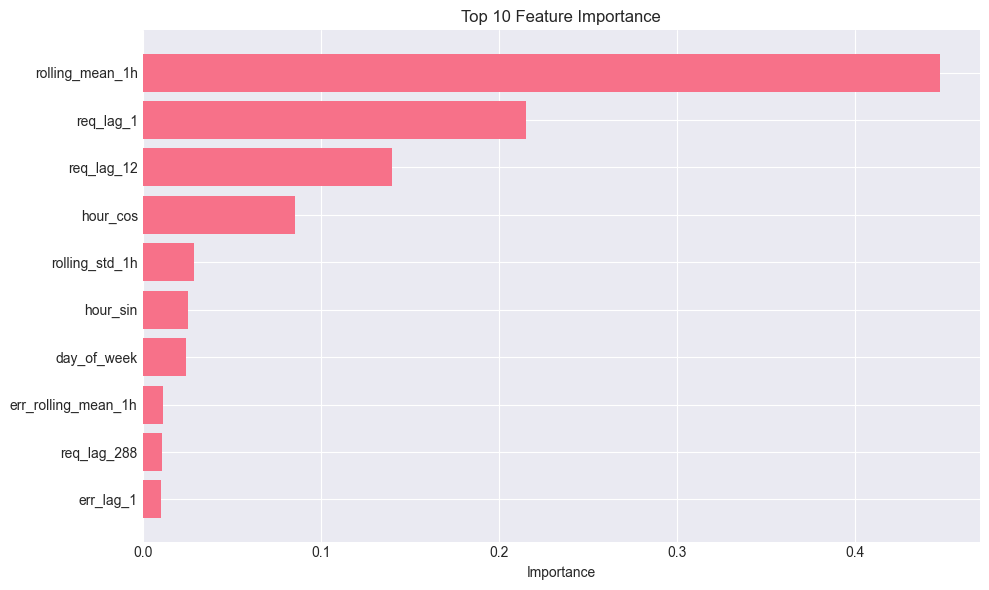


VISUALIZATION...


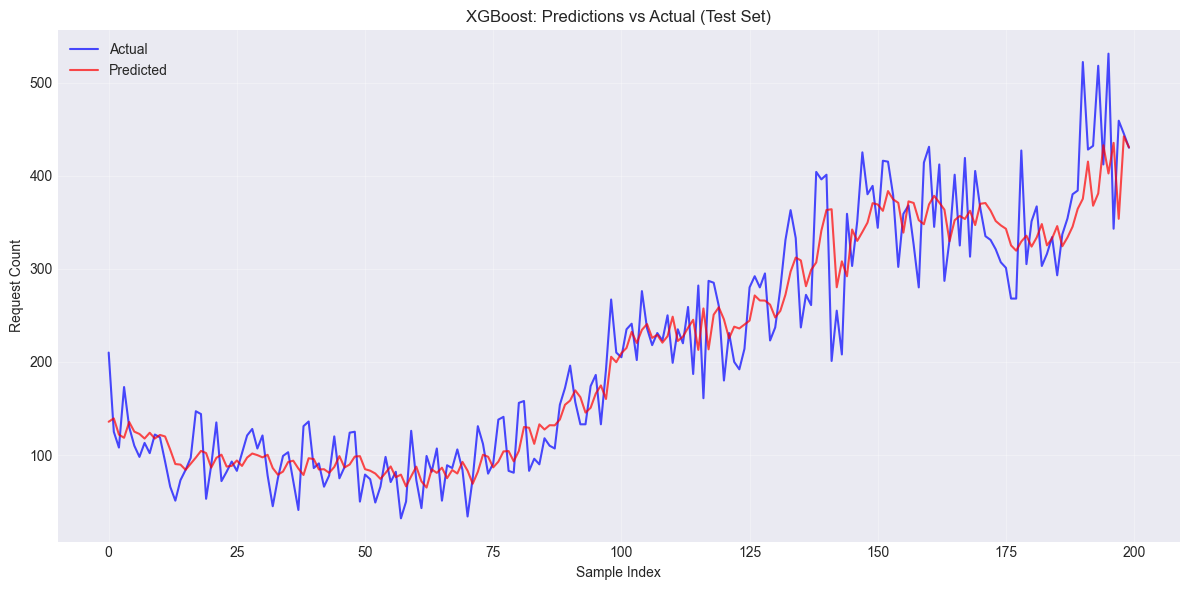


SAVING MODEL...
Model saved to xgboost_forecaster.pkl


In [30]:
if __name__ == "__main__":
    results = run_xgboost()

In [25]:
print(df.index.dtype)
print(df.index.tz)

datetime64[ns, UTC-04:00]
UTC-04:00
